### Multi-class Logistic Regression

In [254]:
import numpy as np
import sklearn
import scipy
import matplotlib.pyplot as plt

In [238]:
# import datasets
X_train = np.loadtxt('X_train.csv',delimiter = ',')
X_test = np.loadtxt('X_test.csv',delimiter = ',')
y_train = np.loadtxt('y_train.csv',delimiter = ',')
y_test = np.loadtxt('y_test.csv',delimiter = ',')

In [239]:
# W has dimensions of p times l. p is number of predictors and l is number of classes of y
# x has dimensions of n times p
# y has dimensions of n times 1

In [240]:
# function of w times x
def linear_combination(x,w):
    # dot product of w and x
    z = np.dot(x,w)
    
    return z

In [241]:
# function of generating dummy response variables
def dummy_response(y,nclass):
    # create dummy var matrix
    z = np.zeros((np.shape(y)[0],nclass))
    
    # change corresponding values
    for i in range(np.shape(y)[0]):
        z[i,int(y[i])] = 1
    
    return z

In [242]:
# function of negative log-likelihood
def multiclass_neg_log_likelihood(x,y,w,nclass):
    # number of observations
    n = np.shape(x)[0]
    
    # dummy response
    z = dummy_response(y,nclass)
    
    # for each observation, calculate f and sum up
    sum_f = 0
    for i in range(n):
        # take out corresponding row of x and y
        x_i = x[i:i+1,]
        
        #for each class k, calculate z*ln(p) and sum up
        for k in range(nclass):
            f = 0
            
            # calculate numerator and demoninator of probability function
            numerator = np.exp(linear_combination(x_i,w[:,k:k+1]))
            denominator = np.sum(np.exp(linear_combination(x_i,w)))
            if denominator==0:
                print('Denominator of 0 found.')
            # calculate f function
            ln_p = -np.log(numerator/denominator)
            
            # add individual f function 
            f += (z[i,k] * ln_p)
        
        # sum up
        sum_f += f
    
    # calculate negative log-likelihood
    R = sum_f / n
    
    return R

In [243]:
# function of gradient of negative log-likelihood (index of i)
# this function only take gradient of a certain observation, instead of sum up all observations
def grad_multiclass_neg_log_likelihood(x,y,w,nclass,i):
        
    # dummy response
    z = dummy_response(y,nclass)
    
    # take out corresponding row of x and y
    x_i = x[i:i+1,]
        
    # stack column of x_i nclass times to get initial w 
    grad_f = np.tile(x_i.T,(1,nclass))
        
    # for each class k, calculate z*ln(p) and sum up
    for k in range(nclass):
            
            
        # calculate numerator and demoninator of probability function
        numerator = np.exp(linear_combination(x_i,w[:,k:k+1]))
        denominator = np.sum(np.exp(linear_combination(x_i,w)))
        
        # calculate grad_f
        p_minus_z = numerator/denominator - z[i,k]
            
        grad_f[:,k] = grad_f[:,k] * p_minus_z
        
    
    return grad_f

In [244]:
# function of make prediction for single observation
def predict(x,y,w,nclass):
    # calculate probs of classes
    probs = np.exp(linear_combination(x,w)) 
    
    # select the index of largest prob
    max_index = np.argmax(probs)
    
    return max_index

# function of judge if single observation correctly predicted
def correct_prediction(x,y,w,nclass):
    z = dummy_response(y,nclass)
    
    # prediction result
    pred = predict(x,y,w,nclass)
    # indicator of if correctly predicted
    correct = 0
    
    if z[:,pred]==1:
        correct = 1
    
    # return 1 if correct, 0 o.w.
    return correct

# function of accuracy of dataset
def accuracy(x,y,w,nclass):
    # number of observations
    n = np.shape(x)[0]
    # number of correct prediction
    sum_correct = 0
    
    # check each observation if correctly predicted
    for i in range(n):
        x_i = x[i:i+1,]
        y_i = y[i:i+1,]
        
        if_correct = correct_prediction(x_i,y_i,w,nclass)
        sum_correct += if_correct
    
    return (sum_correct/n)

In [246]:
# function of gradient descent
# loss_and_grad is the list of [loss function, gradient of loss function]
# acc_func is the function for accuracy calculation
def gradient_descent(x_train,y_train,x_test,y_test,loss_and_grad,init_w,alpha,n_its,acc_func):
    # loss function and its gradient
    loss = loss_and_grad[0]
    grad_loss = loss_and_grad[1]
    
    # history of w, loss, and acc_test
    w_hist = []
    train_loss_hist = []
    test_loss_hist = []
    acc_test_hist = []
    
    # initiate w
    w = init_w
    # number of classes
    n_class = np.shape(np.unique(y_train))[0]
    # number of train observations
    n_train = np.shape(x_train)[0]
    
    # loss and acc_test
    new_train_loss = loss(x_train,y_train,w,n_class)
    new_test_loss = loss(x_test,y_test,w,n_class)
    new_acc_test = acc_func(x_test,y_test,w,n_class)
    # append history
    w_hist.append(w)
    train_loss_hist.append(new_train_loss)
    test_loss_hist.append(new_test_loss)
    acc_test_hist.append(new_acc_test)
    
    # n_its interations of descent
    for iteration in range(n_its):
        # calculate sum of grad
        grad = 0
        # for each observation
        for i in range(n_train):
            grad_i = grad_loss(x_train,y_train,w,n_class,i)
            grad += grad_i
        grad = grad / n_train
        
        # gradient descent
        w = w - alpha * grad
        
        # loss and acc_test
        new_train_loss = loss(x_train,y_train,w,n_class)
        new_test_loss = loss(x_test,y_test,w,n_class)
        new_acc_test = acc_func(x_test,y_test,w,n_class)
        
        # append history
        w_hist.append(w)
        train_loss_hist.append(new_train_loss)
        test_loss_hist.append(new_test_loss)
        acc_test_hist.append(new_acc_test)
        
    print('Epoch: '+str(iteration+1))
    print('Test accuracy='+str(new_acc_test))
        
    return w_hist, train_loss_hist, test_loss_hist, acc_test_hist

In [247]:
# function of generating normalizing function
def standard_normalizer(x):
    # compute the mean and standard deviation of x
    x_means = np.mean(x,axis = 0)
    x_stds = np.std(x,axis = 0) 

    # create standard normalizer function based on input data statistics
    normalizer = lambda data: (data - x_means)/x_stds
    
    # return normalizer and inverse_normalizer
    return normalizer

In [248]:
# normalize datasets
normalizer = standard_normalizer(X_train)
X_train_norm = normalizer(X_train)
X_test_norm = normalizer(X_test)

In [249]:
# initiate W
W = np.ones((16,10))
# gradient descent calculation
w,train_l,test_l,a = gradient_descent(X_train_norm,y_train,X_test_norm,y_test,[multiclass_neg_log_likelihood,grad_multiclass_neg_log_likelihood],W,2**(5),20,accuracy)

Epoch: 20
Test accuracy=0.8459119496855346


In [251]:
# function of stochastic gradient descent
# loss_and_grad is the list of [loss function, gradient of loss function]
# acc_func is the function for accuracy calculation
def stochastic_gradient_descent(x_train,y_train,x_test,y_test,loss_and_grad,init_w,alpha,n_its,acc_func):
    # loss function and its gradient
    loss = loss_and_grad[0]
    grad_loss = loss_and_grad[1]
    
    # history of w, loss, and acc_test
    w_hist = []
    train_loss_hist = []
    test_loss_hist = []
    acc_test_hist = []
    
    # initiate w
    w = init_w
    # number of classes
    n_class = np.shape(np.unique(y_train))[0]
    # number of train observations
    n_train = np.shape(x_train)[0]
    
    # loss and acc_test
    new_train_loss = loss(x_train,y_train,w,n_class)
    new_test_loss = loss(x_test,y_test,w,n_class)
    new_acc_test = acc_func(x_test,y_test,w,n_class)
    # append history
    w_hist.append(w)
    train_loss_hist.append(new_train_loss)
    test_loss_hist.append(new_test_loss)
    acc_test_hist.append(new_acc_test)
    
    # index of observations
    index = np.array(range(n_train))
    
    # n_its interations of descent
    for iteration in range(n_its):

        # reshuffle dataset index
        np.random.shuffle(index)
        
        # for each observation
        for i in index:
            grad_i = grad_loss(x_train,y_train,w,n_class,i)
            # individual gradient descent
            w = w - alpha/np.sqrt(iteration+1) * grad_i
        
        # loss and acc_test
        new_train_loss = loss(x_train,y_train,w,n_class)
        new_test_loss = loss(x_test,y_test,w,n_class)
        new_acc_test = acc_func(x_test,y_test,w,n_class)
        
        # append history
        w_hist.append(w)
        train_loss_hist.append(new_train_loss)
        test_loss_hist.append(new_test_loss)
        acc_test_hist.append(new_acc_test)
        
    print('Epoch: '+str(iteration+1))
    print('Test accuracy='+str(new_acc_test))
        
    return w_hist, train_loss_hist, test_loss_hist, acc_test_hist 

In [252]:
# initiate W
W = np.ones((16,10))
# stochastic gradient descent calculation
w_s,train_l_s,test_l_s,a_s = stochastic_gradient_descent(X_train_norm,y_train,X_test_norm,y_test,[multiclass_neg_log_likelihood,grad_multiclass_neg_log_likelihood],W,2**(-2),20,accuracy)

Epoch: 20
Test accuracy=0.9036592338479131


In [272]:
# convert elements of list to number
train_l_ = []
for i in train_l:
    train_l_.append(i[0][0])
test_l_ = []
for i in test_l:
    test_l_.append(i[0][0])
train_l_s_ = []
for i in train_l_s:
    train_l_s_.append(i[0][0])
test_l_s_ = []
for i in test_l_s:
    test_l_s_.append(i[0][0])

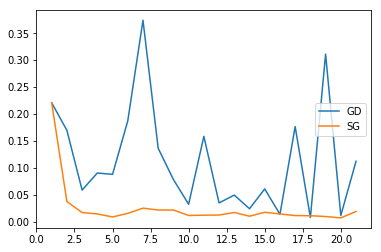

In [278]:
# plot train loss
epoch_list = np.linspace(1,21,21)
plt.plot(epoch_list,train_l_)
plt.plot(epoch_list,train_l_s_)
plt.legend(['GD','SG'], loc='center right')
plt.show()

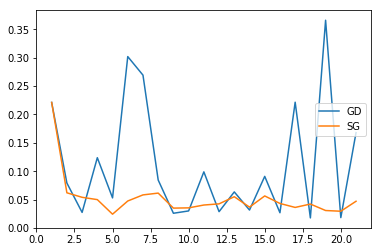

In [282]:
# plot test loss
plt.plot(epoch_list,test_l_)
plt.plot(epoch_list,test_l_s_)
plt.legend(['GD','SG'], loc='center right')
plt.show()

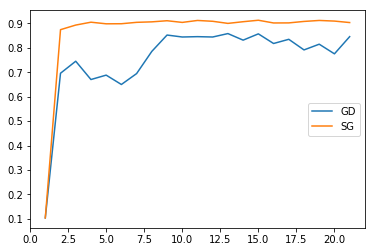

In [283]:
# plot test accuracy
plt.plot(epoch_list,a)
plt.plot(epoch_list,a_s)
plt.legend(['GD','SG'], loc='center right')
plt.show()

In [287]:
# function of gradient descent with regularization
# loss_and_grad is the list of [loss function, gradient of loss function]
# acc_func is the function for accuracy calculation
def gradient_descent_regularization(x_train,y_train,x_test,y_test,loss_and_grad,init_w,alpha,min_grad,acc_func,reg_lambda):
    # loss function and its gradient
    loss = loss_and_grad[0]
    grad_loss = loss_and_grad[1]
    
    # history of w, loss, and acc_test
    w_hist = []
    loss_hist = []
    acc_test_hist = []
    
    # initiate w
    w = init_w
    # number of classes
    n_class = np.shape(np.unique(y_train))[0]
    # number of train observations
    n_train = np.shape(x_train)[0]
    
    # loss and acc_test
    new_loss = loss(x_train,y_train,w,n_class)
    new_acc_test = acc_func(x_test,y_test,w,n_class)
    # append history
    w_hist.append(w)
    loss_hist.append(new_loss)
    acc_test_hist.append(new_acc_test)
    
    # initialize magnitude of gradient of f (>0.01)
    mag_grad = 1
    epoch = 1
    
    # n_its interations of descent
    while mag_grad>=min_grad:
        # calculate sum of grad
        grad = 0
        # for each observation
        for i in range(n_train):
            grad_i = grad_loss(x_train,y_train,w,n_class,i)
            grad += grad_i
        grad = grad / n_train
        
        # add gradient of regularization
        grad += reg_lambda * w
        mag_grad = np.linalg.norm(grad)
        
        # gradient descent
        w = w - alpha*grad
        
        # loss and acc_test
        new_loss = loss(x_train,y_train,w,n_class)
        new_acc_test = acc_func(x_test,y_test,w,n_class)
        
        # append history
        w_hist.append(w)
        loss_hist.append(new_loss)
        acc_test_hist.append(new_acc_test)
        
        print('Epoch: '+str(epoch))
        print('Grad='+str(mag_grad))
        print('Test accuracy='+str(new_acc_test))
        print('')
        epoch += 1
        
    return w_hist, loss_hist, acc_test_hist

In [285]:
X_train_2 = X_train[:3748,]
y_train_2 = y_train[:3748,]
X_val_2 = X_train[3748:,]
y_val_2 = y_train[3748:,]

# normalize datasets
normalizer_2 = standard_normalizer(X_train_2)
X_train_2_norm = normalizer_2(X_train_2)
X_val_2_norm = normalizer_2(X_val_2)
X_test_2_norm = normalizer_2(X_test)

In [288]:
# initiate W
W = np.ones((16,10))
# calculation with lambda of 0
w_r,l_r,a_r = gradient_descent_regularization(X_train_2_norm,y_train_2,X_val_2_norm,y_val_2,[multiclass_neg_log_likelihood,grad_multiclass_neg_log_likelihood],W,8,0.01,accuracy,0)

Epoch: 1
Grad=0.917199129505
Test accuracy=0.7541377469300587

Epoch: 2
Grad=0.375155054311
Test accuracy=0.7605445808862787

Epoch: 3
Grad=0.402221555671
Test accuracy=0.7362520021356114

Epoch: 4
Grad=0.421179317276
Test accuracy=0.7749599572877737

Epoch: 5
Grad=0.421230865073
Test accuracy=0.799252536038441

Epoch: 6
Grad=0.32241043772
Test accuracy=0.8753336892685532

Epoch: 7
Grad=0.142039763143
Test accuracy=0.8878804057661506

Epoch: 8
Grad=0.0965252983482
Test accuracy=0.899359316604378

Epoch: 9
Grad=0.0647802300003
Test accuracy=0.9033635878270155

Epoch: 10
Grad=0.0525004240502
Test accuracy=0.9054991991457555

Epoch: 11
Grad=0.043596780889
Test accuracy=0.909503470368393

Epoch: 12
Grad=0.0384019161765
Test accuracy=0.9137746930058729

Epoch: 13
Grad=0.0341388102405
Test accuracy=0.9137746930058729

Epoch: 14
Grad=0.0311489716082
Test accuracy=0.9167111585691404

Epoch: 15
Grad=0.0286698308835
Test accuracy=0.9177789642285105

Epoch: 16
Grad=0.026847669614
Test accuracy=0.

In [289]:
# calculate test accuracy
accuracy(X_test_2_norm,y_test,w_r[61],10)

0.8907947398513436